# <center> Plotting shockdata read from a .hdf5-file </center>  

In this notebook is an example of how to plot the results from the rippled shock simulations. We start with reading the results from the hdf5-file and writing them to pandas dataframes for ease of use. Then we calculate some additional results for the plot and finally we plot the results.

We start with importing needed libraries and defining a needed cutoffVelocity function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
#%matplotlib inline

In [2]:
def cutoffVelocity(v_0, u, r, r_mag, T, lam=1):
    return (v_0 + 0.5*((u**2)/lam)*((r - 1)/r)*((r_mag**2)/(r+(r_mag**2)))*T)

We start by opening the file. If the file is in the same directory as this jupyter notebook then just the name is needed. If you have the results in a different directory you need to specify the whole directory path.

Listing the keys will show what simulations are saved to this file.

In [3]:
#Open the file and see what groups it has
file = h5py.File("exampletest.hdf5", "r")
list(file.keys())

['1ex', '2ex']

In this example I have run two simulations with different ripple chances, but otherwise the parameters are the same. As such we can open the first group and read all the parameters from there except for the ripple chance which we save for both groups seperately. I also print the keys inside the groups to see what savesteps the simulation has done.

In [4]:
group = file["1ex"]

print(list(group.attrs))

mfp = group.attrs['meanfreepath']
obliquity_mean = group.attrs['obliquity_mean']
particles_total = group.attrs['particles_total']
r = group.attrs['r']
ripple_amplitude = group.attrs['ripple_amplitude']

ripple_chance_1ex = group.attrs['ripple_chance']

ripple_velocity_x = group.attrs['ripple_velocity_x']
ripple_velocity_y = group.attrs['ripple_velocity_y']
ripple_wavelength = group.attrs['ripple_wavelength']
runtime = group.attrs['runtime']
savesteps = group.attrs['savesteps']
t_max = group.attrs['t_max']
v_up = group.attrs['v_up']

print("Group 1ex saves: ", list(group.keys()))

group = file["2ex"]

ripple_chance_2ex = group.attrs['ripple_chance']

print("Group 2ex saves: ", list(group.keys()))

['meanfreepath', 'obliquity_mean', 'particles_total', 'r', 'ripple_amplitude', 'ripple_chance', 'ripple_velocity_x', 'ripple_velocity_y', 'ripple_wavelength', 'runtime', 'savesteps', 't_max', 'v_up']
Group 1ex saves:  ['T=0', 'T=500']
Group 2ex saves:  ['T=0', 'T=500']


Next we open the groups seperately and read the results to pandas dataframes. Here using a notebook is handy since you can run this cell with the first group and then just change the group name and rerun the cell. As long as you remember to change the final dataframe name both of the results are saved to memory for future use.

In [6]:
#Choose which group we open
group = file["2ex"]
print(list(group.keys()))

#Read the results from the .hdf5-file and write them to a pandas dataframe
#choose what savestep you want to read
dset_end = group["T=500"]
data_end = pd.DataFrame(dset_end[...], columns=["particle", "position", "velocity", "t_end", "mu"])

#Add the logarithm of the velocity to the dataframe
velocity_log = np.log10(data_end["velocity"])
data_end["velocity_log"] = velocity_log

#remember to change the name of the final dataframe so you don't accidentally replace the previous 
#data_end1 = data_end
data_end2 = data_end

['T=0', 'T=500']


In [7]:
#Remember to close the file 
file.close()

Next we calculate the cutoff velocity and the power law to be used in the plot.

In [8]:
#Tangent of the obliquity is needed in the magnetic compression calculation
obtan = np.tan(obliquity_mean)

#Calculate the new magnetic compression ratio
r_mag = np.sqrt(1.0 + r*r*obtan*obtan) / np.sqrt(1.0 + obtan*obtan)

#use the simulation parameters to calculate the cutoff velocity of the simulations
v_c20 = cutoffVelocity(6.0, v_up, r, r_mag, t_max)

#Here we calculate the power law that the results are compared to
gamma = (r + 2.0) / (r - 1.0)
powerlaw = 1.0 - gamma
powerx = np.linspace(np.log10(6.0), np.log10(v_c20), 1000)
#Change the floating point value here to adjust the power law to be close to the results
powery = 5.2 + powerlaw*powerx

Finally, we plot the results.

C:\Users\Frans\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
C:\Users\Frans\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10


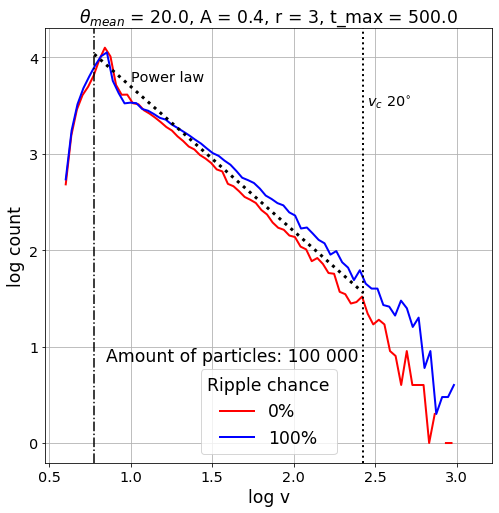

In [9]:
#Give the size of the plot
plt.figure(figsize=[8, 8])

#Decide to how many bins you want to divide the results
#adding more bins gives more accurate results, but more noise
bns = 70

#Run all the results you want to plot through the histogram calculation
#We plot the logarithm of the velocity to histogram to save the number of particles in each bar
n1, bins, patches = plt.hist(data_end1['velocity_log'], bins=bns)

#Also save the starting point of all the histograms as we use them as the x-position
#The width of each bar is also calculated, but not used in this example
bin_s1 = bins[0:bins.size-1]
bin_w1 = bins[1:bins.size] - bins[0:bins.size-1]

#If you correctly ran the reading cell twice then you can also run the second groups results
n2, bins, patches = plt.hist(data_end2['velocity_log'], bins=bns)

bin_s2 = bins[0:bins.size-1]
bin_w2 = bins[1:bins.size] - bins[0:bins.size-1]




# Clear the histogram plot and replace it with a line plot.
plt.clf()

#Plot the simulation results
plt.plot(bin_s1, np.log10(n1), color="red", label=r"0%", linewidth=2.0)
plt.plot(bin_s2, np.log10(n2), color="blue", label=r"100%", linewidth=2.0)

#add the vercial lines for the particle starting velocity and cutoff velocity
plt.axvline(x=(np.log10(6.0)), color="black", linestyle="-.")
plt.axvline(x=(np.log10(v_c20)), color="black", linestyle=":", linewidth=2.0)

#add the power law
plt.plot(powerx, powery, color="black", linestyle="dotted", linewidth=3.0)

#give names to the x and y axes 
plt.xlabel("log v", fontsize="xx-large")
plt.ylabel("log count", fontsize="xx-large")

#Change the size of the numbers on the axes
plt.tick_params(labelsize="x-large")

#Title your plot
plt.title(r"$\theta_{mean}$ = 20.0, A = 0.4, r = 3, t_max = 500.0", fontsize="xx-large")

#Place the legend of the plot. Using "best" automatically finds the place where the legend is least intrusive.
plt.legend(loc="best", title="Ripple chance", fontsize="xx-large", title_fontsize="xx-large")

#Using annotate you can add text to the plot where you want 
plt.annotate("Amount of particles: 100 000", (0.85,0.85), fontsize="xx-large")
#plt.annotate("Total simulation time: 500", (1.0,1.1), fontsize="xx-large")
plt.annotate(r"$v_c$ 20$^{\circ}$", (2.45,3.5), fontsize="x-large")
plt.annotate("Power law", (1.0,3.75), fontsize="x-large")

#Adds a grid. I liked it, but not necessary at all.
plt.grid()

#Finally give a name to your plot 
plt.savefig("20deg_r3_diffChance.png")

#There might be warnings about dividing by zero, because some of the bars in the histogram were zero

## Bonus: Calculating ripple angles

As a bonus heres  way to calculate the minimum and maximum angles a rippled shock achieves with different ripple parameters. As the simulation cannot handle angles above 90 degrees you can use this to check what ripples are possible to simulate.

In [10]:
def calculateCompressionRatios(randomx, randomy, obliquity_mean, ripple_amplitude, ripple_wavelength):
    
    #Calculate the ripple strength
    #a = 2.0 * np.pi * ripple_amplitude / ripple_wavelength
    a = ripple_amplitude
    
    #Calculate the semi-random obliquity of the shock
    numerator = np.cos(obliquity_mean) - a * np.sin(obliquity_mean) * np.cos(randomx) * np.sin(randomy)
    denominator = np.sqrt( a*a*(np.cos(randomx)**2 * np.sin(randomy)**2 + np.cos(randomy)**2 * np.sin(randomx)**2) + 1.0 )
    
    obliquity = np.arccos( numerator/denominator )
    
    return obliquity

In [11]:
#Only change these three values
mean_obliquity_in_deg = 20.0
test_ripple_amplitude = 0.4
test_ripple_wavelength = 1.0


Theta = np.deg2rad(mean_obliquity_in_deg)
a = test_ripple_amplitude * (2.0*np.pi) / test_ripple_wavelength
x0 = np.linspace(0.0, 1.0, 1000)
y0 = np.linspace(0.0, 1.0, 1000)

xmesh, ymesh = np.meshgrid(x0,y0)
x = 2*np.pi*xmesh
y = 2*np.pi*ymesh

z = a/(2*np.pi) * np.sin(x) * np.sin(y)
costheta = calculateCompressionRatios(x, y, Theta, a, test_ripple_wavelength)

costheta_min = np.min(costheta)
theta_min = np.rad2deg(costheta_min)
costheta_max = np.max(costheta)
theta_max = np.rad2deg(costheta_max)
print('theta_min = ', theta_min)
print('theta_max = ', theta_max)

theta_min =  0.08463207145133166
theta_max =  88.30299169883064
